# V-Unet v1.2 
Training condition: 

- Pre-train with 200 LUS (without horizontally flipped version) (train-test-split of 0.8) 
  - Learning rate 1e-5, trained with 100 epochs
- Fine-tune with the same LUS dataset, with 5 fold cross validation
  - Learning rate 5e-6, trained with 100 epochs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Lung_Segmentation

/content/gdrive/MyDrive/Lung_Segmentation


In [ ]:
from DataPreprocessing import *
from ValidationAndPrediction import * 
from Model import *
import os
import re
import numpy as np
import pandas as pd
import natsort
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8221447395230980838
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14798763221025963891
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# 1. Data Exploration 

Preparing the training dataset list

In [ ]:
train_image_path = 'Lung_seg_data/NEW_TIF_IMG'
train_mask_path = 'Lung_seg_data/NEW_TIF_MASK'
train_images, train_masks = train_filepath_list(train_image_path, train_mask_path)
print('Number of train dataset: ', len(train_images))

Number of train dataset:  200


Display one of the images and masks as example

Image shape:  (960, 128)
Mask shape:  (960, 128)


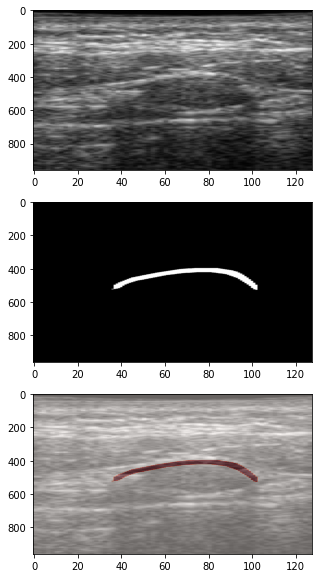

In [ ]:
image_display(train_images, train_masks, 0)

# 2. Data Preprocess: Data Augmentation
**we only use 200 images (no flipping)**

**Creating a pandas Dataframe for all the filepaths of both original and generated dataset**
- use function `train_dataframe`

In [ ]:
aug_images = train_images
aug_masks = train_masks 

df = train_dataframe(aug_images, aug_masks)
display(df)

,filename,mask
0,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_335.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_335.tif
1,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_815.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_815.tif
2,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_445.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_445.tif
3,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_125.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_125.tif
4,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_840.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_840.tif
...,...,...
195,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_135.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_135.tif
196,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_130.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_130.tif
197,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_820.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_820.tif
198,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_840.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_840.tif


**Use `ImageDataGenerator` for data augmentation**
- use function `train_generator`
- can generate images and masks at the same time using the same seed for the image and masks generators to ensure same transformation between corresponding images and masks 
- to be used in model training process

In [ ]:
# Defining data augmentation dictionary 
train_generator_args = dict(rotation_range=0.15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Redefine the input size of the images 
width = 256
height = 256
channel = 3

# To visualize the results of generator: set save_to_dir = "your path"
aug_img_dir = None
aug_mask_dir = None
aug_img_prefix = None
aug_mask_prefix = None
aug_format = None

# 3. Transfer Learning with U-Net
**Use of pre-trained model (VGG16) for transfer learning**

see function `TL_unet_model(input_shape)`, which has VGG16 encoder frozen

In [ ]:
input_shape = (height, width, channel)
#output_shape = (256, 256, 1)
K.clear_session()
unet_model = TL_unet_model(input_shape)


58892288/58889256 [==============================] - 0s 0us/step
(None, 16, 16, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
(None, 256, 256, 1)


In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

Display U-Net architecture

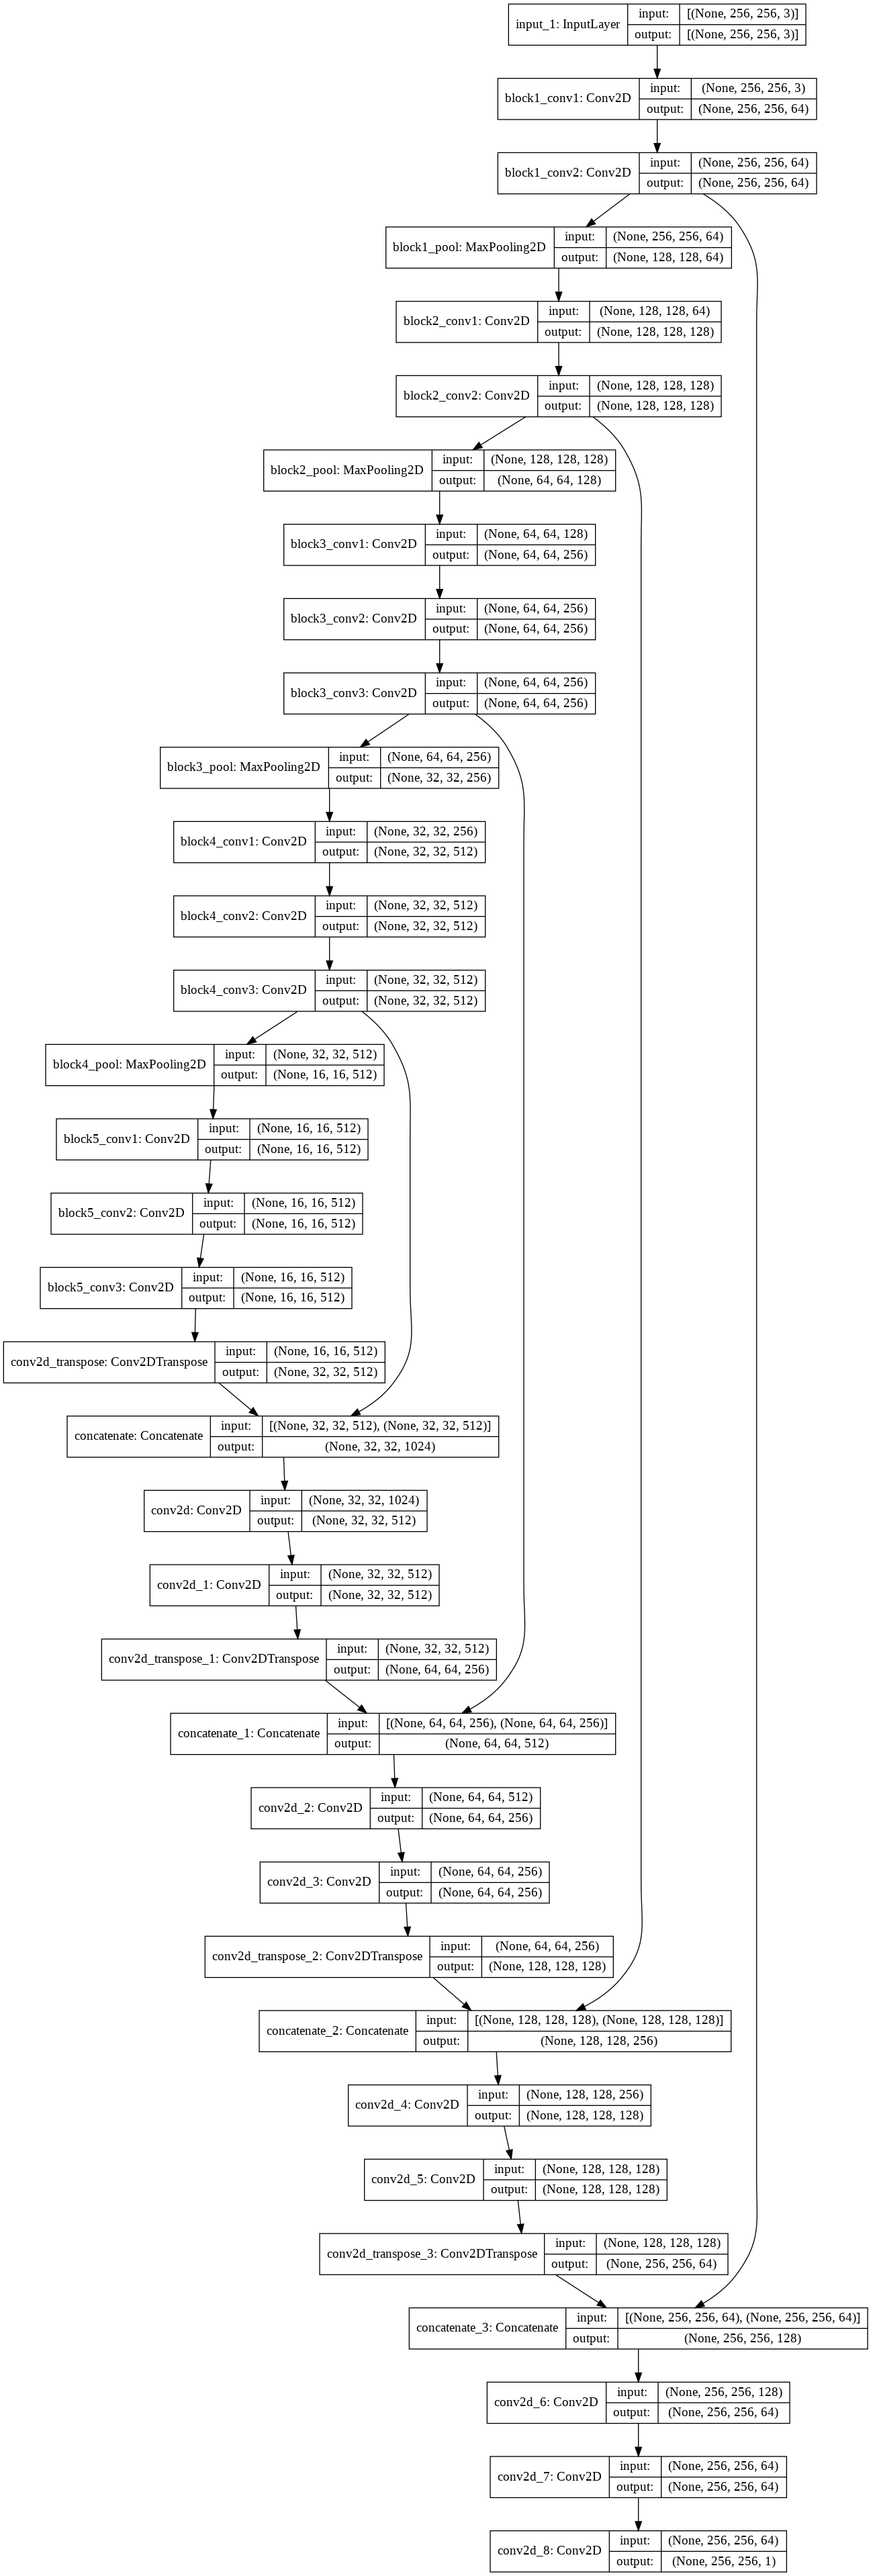

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(unet_model,to_file='new_unet_struct.png',show_shapes=True, show_layer_names=True)

from IPython.display import Image as IP_Image
IP_Image(retina=True, filename='new_unet_struct.png')

Display the layers status (trainable or non-trainable)

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in unet_model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(unet_model_df)

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


# 4. Training the transfer learning U-Net model

Splitting the dataset: 80% for training, 20% for validation and testing

In [ ]:
kf = KFold(n_splits = 5, shuffle=True)
for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

print("Training Dataset:")
display(train_df)
print("Validation and Testing Dataset")
display(test_df)

Training Dataset:


,filename,mask
0,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_15.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_15.tif
1,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_750.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_750.tif
2,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_110.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_110.tif
4,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_10.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_10.tif
5,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_330.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_330.tif
...,...,...
191,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_825.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_825.tif
194,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_635.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_635.tif
197,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_745.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_745.tif
198,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_750.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_750.tif


Validation and Testing Dataset


,filename,mask
3,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_310.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_310.tif
6,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_815.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_815.tif
14,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_115.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_115.tif
15,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_40.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_40.tif
17,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_435.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_435.tif
34,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_345.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_345.tif
36,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_140.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_140.tif
38,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_640.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_640.tif
45,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_325.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_325.tif
50,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_830.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_830.tif


 **Model training**

In [ ]:
batch_size = 20
epochs = 100

# Defining the train generator and test generator: 
train_gen = train_generator(train_df, batch_size, 
                          None, 
                          train_generator_args,
                          aug_img_dir, aug_mask_dir, 
                          aug_img_prefix, aug_mask_prefix,
                          aug_format,
                          (height, width))

test_gen = train_generator(test_df, batch_size,
                           None, 
                           dict(),
                           None, None, None, None, None, 
                           (height, width))

# Train the model with `.fit_generator()`
unet_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, 
                    metrics=[iou, dice_coef, 'binary_accuracy'])

checkpoint_path = 'V_Unet/model_v1_2/v1_2_pretrain_unet_lungseg.hdf5'


model_checkpoint = ModelCheckpoint(checkpoint_path,  
                                    verbose=1,
                                    monitor='val_loss',
                                    save_best_only=True)

pretrain_csvlogger = CSVLogger(filename='V_Unet/model_v1_2/v1_2_pretrain_training_log.csv', separator=",", append=True)

callbacks_list = [model_checkpoint, pretrain_csvlogger]

history = unet_model.fit_generator(train_gen,
                                    steps_per_epoch=len(df)//batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    validation_data = test_gen, 
                                    validation_steps = len(test_df)//batch_size,
                                    verbose=1)

/Users/chengdorothy/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/chengdorothy/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 160 validated image filenames.
Found 160 validated image filenames.
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: -0.0408 - iou: 0.0208 - dice_coef: 0.0408 - binary_accuracy: 0.0214 Found 40 validated image filenames.
Found 40 validated image filenames.
10/10 [==============================] - 388s 40s/step - loss: -0.0408 - iou: 0.0208 - dice_coef: 0.0408 - binary_accuracy: 0.0214 - val_loss: -0.0415 - val_iou: 0.0212 - val_dice_coef: 0.0415 - val_binary_accuracy: 0.0223

Epoch 00001: val_loss improved from inf to -0.04148, saving model to Lung_seg_data/v1_2_pretrain_unet_lungseg.hdf5
Epoch 2/100
10/10 [==============================] - 331s 33s/step - loss: -0.0414 - iou: 0.0211 - dice_coef: 0.0414 - binary_accuracy: 0.0223 - val_loss: -0.0413 - val_iou: 0.0211 - val_dice_coef: 0.0413 - val_binary_accuracy: 0.0240

Epoch 00002: val_loss did not improve from -0.04148
Epoch 3/100
10/10 [==============================] - 360s 36s/step - loss: -0.0420 - iou: 


Epoch 00023: val_loss improved from -0.48368 to -0.49059, saving model to Lung_seg_data/v1_2_pretrain_unet_lungseg.hdf5
Epoch 24/100
10/10 [==============================] - 382s 39s/step - loss: -0.5132 - iou: 0.3453 - dice_coef: 0.5132 - binary_accuracy: 0.9816 - val_loss: -0.4977 - val_iou: 0.3313 - val_dice_coef: 0.4977 - val_binary_accuracy: 0.9835

Epoch 00024: val_loss improved from -0.49059 to -0.49766, saving model to Lung_seg_data/v1_2_pretrain_unet_lungseg.hdf5
Epoch 25/100
10/10 [==============================] - 392s 39s/step - loss: -0.5267 - iou: 0.3576 - dice_coef: 0.5267 - binary_accuracy: 0.9822 - val_loss: -0.5112 - val_iou: 0.3435 - val_dice_coef: 0.5112 - val_binary_accuracy: 0.9829

Epoch 00025: val_loss improved from -0.49766 to -0.51121, saving model to Lung_seg_data/v1_2_pretrain_unet_lungseg.hdf5
Epoch 26/100
10/10 [==============================] - 390s 39s/step - loss: -0.5420 - iou: 0.3719 - dice_coef: 0.5420 - binary_accuracy: 0.9826 - val_loss: -0.5330 -

Epoch 48/100
10/10 [==============================] - 386s 39s/step - loss: -0.6809 - iou: 0.5162 - dice_coef: 0.6809 - binary_accuracy: 0.9866 - val_loss: -0.6859 - val_iou: 0.5219 - val_dice_coef: 0.6859 - val_binary_accuracy: 0.9870

Epoch 00048: val_loss improved from -0.67454 to -0.68587, saving model to Lung_seg_data/v1_2_pretrain_unet_lungseg.hdf5
Epoch 49/100
10/10 [==============================] - 379s 38s/step - loss: -0.6863 - iou: 0.5226 - dice_coef: 0.6863 - binary_accuracy: 0.9870 - val_loss: -0.6806 - val_iou: 0.5158 - val_dice_coef: 0.6806 - val_binary_accuracy: 0.9865

Epoch 00049: val_loss did not improve from -0.68587
Epoch 50/100
10/10 [==============================] - 388s 39s/step - loss: -0.6821 - iou: 0.5177 - dice_coef: 0.6821 - binary_accuracy: 0.9869 - val_loss: -0.6891 - val_iou: 0.5258 - val_dice_coef: 0.6891 - val_binary_accuracy: 0.9865

Epoch 00050: val_loss improved from -0.68587 to -0.68912, saving model to Lung_seg_data/v1_2_pretrain_unet_lungseg.hd

10/10 [==============================] - 359s 36s/step - loss: -0.7147 - iou: 0.5563 - dice_coef: 0.7147 - binary_accuracy: 0.9883 - val_loss: -0.7121 - val_iou: 0.5531 - val_dice_coef: 0.7121 - val_binary_accuracy: 0.9883

Epoch 00074: val_loss did not improve from -0.72532
Epoch 75/100
10/10 [==============================] - 337s 34s/step - loss: -0.7225 - iou: 0.5657 - dice_coef: 0.7225 - binary_accuracy: 0.9887 - val_loss: -0.7176 - val_iou: 0.5596 - val_dice_coef: 0.7176 - val_binary_accuracy: 0.9883

Epoch 00075: val_loss did not improve from -0.72532
Epoch 76/100
10/10 [==============================] - 331s 33s/step - loss: -0.7211 - iou: 0.5641 - dice_coef: 0.7211 - binary_accuracy: 0.9884 - val_loss: -0.7153 - val_iou: 0.5568 - val_dice_coef: 0.7153 - val_binary_accuracy: 0.9879

Epoch 00076: val_loss did not improve from -0.72532
Epoch 77/100
10/10 [==============================] - 324s 33s/step - loss: -0.7247 - iou: 0.5684 - dice_coef: 0.7247 - binary_accuracy: 0.9886 - 

In [ ]:
# Evaluate the generator 
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

TLmodel = load_model(checkpoint_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
TLmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

results = TLmodel.evaluate_generator(evaluate_gen, 
                                    steps=len(test_df)//batch_size,
                                    verbose=1)
results = dict(zip(TLmodel.metrics_names,results))

histories.append(history)
accuracies.append(results['binary_accuracy'])
losses.append(results['loss'])
dicecoefs.append(results['dice_coef'])
ious.append(results['iou'])
 

/Users/chengdorothy/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 40 validated image filenames.
Found 40 validated image filenames.
2/2 [==============================] - 23s 11s/step - loss: -0.7316 - iou: 0.5768 - dice_coef: 0.7316 - binary_accuracy: 0.9886


In [ ]:
print('Evaluation scores from pretrained model:')
print('Accuracy: ', accuracies)
print('Loss: ', losses)
print('Dice coefficient: ', dicecoefs)
print('IOU: ', ious)

Evaluation scores from pretrained model:
Accuracy:  [0.9886363744735718]
Loss:  [-0.7315654158592224]
Dice coefficient:  [0.7315654754638672]
IOU:  [0.5768320560455322]


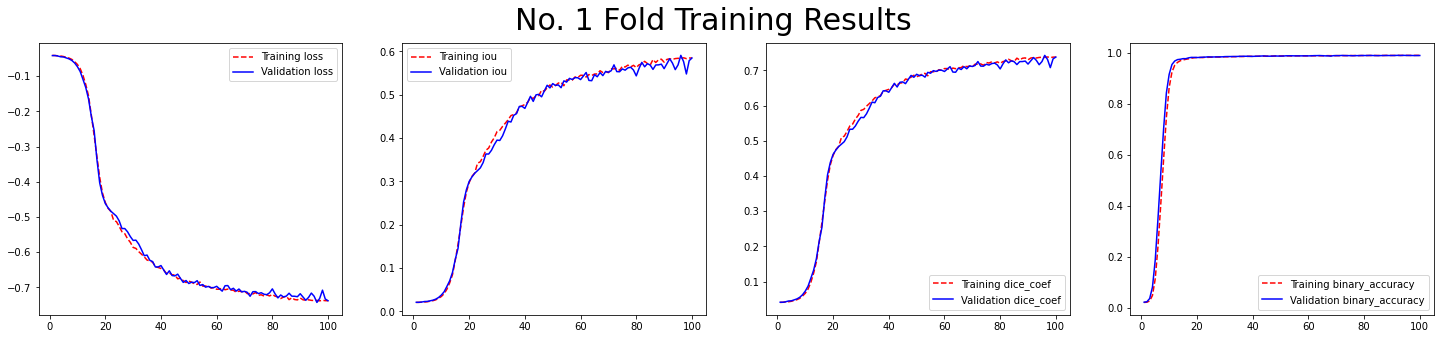

In [ ]:
plot_histories(histories)

# 5. Fine-tuning 
1. Unfreeze the contracting path and retrain it 
2. Apply KFold cross validation (k=5) 
3. Evaluation metrics: dice score, iou

**Unfreeze all layers, use KFold Cross validation**
- For unfreezing use function `finetune_unfreezeall`
    - take the base model (pretrained one) and unfreeze all the layers 

In [ ]:
TL_checkpoint_path = 'model_v1_2/v1_2_pretrain_unet_lungseg.hdf5'
TLmodel = load_model(TL_checkpoint_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
FTmodel = finetune_unfreezeall(input_shape, TLmodel)

FTmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

Apply KFold cross validation (k=5)

In [ ]:
kf_histories = []
kf_losses = []
kf_accuracies = []
kf_dicecoefs = []
kf_ious = []

# same batch size and epochs
epochs = 100
batch_size = 20

# added KFold in here:
kf = KFold(n_splits = 5, shuffle=False)

for k, (train_index, test_index) in enumerate(kf.split(df)):
    kf_train_df = df.iloc[train_index]
    kf_test_df = df.iloc[test_index]
    
    kf_train_gen = train_generator(kf_train_df, batch_size, 
                                None, 
                                train_generator_args,
                                None, None, None, None, None,
                                (height, width))

    kf_test_gen = train_generator(kf_test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))
    
    TLmodel = load_model(TL_checkpoint_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    
    kf_model = finetune_unfreezeall(input_shape, TLmodel)
    kf_model.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])
    
    kf_checkpoint_path = 'V_Unet/model_v1_2/' + str(k+1) + '_v1_2_finetuneKF_unet_lungseg.hdf5'
    
    kf_model_checkpoint = ModelCheckpoint(kf_checkpoint_path,
                                         verbose=1, 
                                         monitor='val_loss',
                                         save_best_only=True)
    # Don't use earlystopping

    kf_csvlogger = CSVLogger(filename='V_Unet/model_v1_2/'+str(k+1)+'_v1_2_finetuneKF_training_log.csv', separator=",", append=True)
    
    kf_callbacks_list = [kf_model_checkpoint, kf_csvlogger]
    
    print('------------------------------------------------------------------------')
    print('Training for fold ', k+1)
    
    kf_history = kf_model.fit_generator(kf_train_gen, 
                                       steps_per_epoch=len(kf_train_df)//batch_size,
                                       epochs=epochs,
                                       callbacks=kf_callbacks_list,
                                       validation_data = kf_test_gen, 
                                       validation_steps = len(kf_test_df)//batch_size,
                                       verbose=1)
    
    KFmodel = load_model(kf_checkpoint_path, 
                       custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])
    
    
    # another generator for evaluate_generator 
    kf_evaluate_gen = train_generator(kf_test_df, batch_size,
                                   None,
                                   dict(),
                                   None, None, None, None, None,
                                   (height, width))
    
    kf_results = KFmodel.evaluate_generator(kf_evaluate_gen, 
                                      steps=len(kf_test_df)//batch_size)
    kf_results = dict(zip(KFmodel.metrics_names,kf_results))
    
    kf_histories.append(kf_history)
    kf_accuracies.append(kf_results['binary_accuracy'])
    kf_losses.append(kf_results['loss'])
    kf_dicecoefs.append(kf_results['dice_coef'])
    kf_ious.append(kf_results['iou'])
 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


------------------------------------------------------------------------
Training for fold  1
Found 160 validated image filenames.
Found 160 validated image filenames.
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: -0.7365 - iou: 0.5830 - dice_coef: 0.7365 - binary_accuracy: 0.9891Found 40 validated image filenames.
Found 40 validated image filenames.
8/8 [==============================] - 134s 12s/step - loss: -0.7365 - iou: 0.5830 - dice_coef: 0.7365 - binary_accuracy: 0.9891 - val_loss: -0.7311 - val_iou: 0.5764 - val_dice_coef: 0.7311 - val_binary_accuracy: 0.9889

Epoch 00001: val_loss improved from inf to -0.73114, saving model to new_training_log_models/1_v1_2_finetuneKF_unet_lungseg.hdf5
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: -0.7338 - iou: 0.5797 - dice_coef: 0.7338 - binary_accuracy: 0.9890 - val_loss: -0.7472 - val_iou: 0.5965 - val_dice_coef: 0.7472 - val_binary_accuracy: 0.9892

Epoch 00002: val_loss improved from -0.73114

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 40 validated image filenames.
Found 40 validated image filenames.
------------------------------------------------------------------------
Training for fold  2
Found 160 validated image filenames.
Found 160 validated image filenames.
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: -0.7375 - iou: 0.5843 - dice_coef: 0.7375 - binary_accuracy: 0.9891Found 40 validated image filenames.
Found 40 validated image filenames.
8/8 [==============================] - 11s 1s/step - loss: -0.7375 - iou: 0.5843 - dice_coef: 0.7375 - binary_accuracy: 0.9891 - val_loss: -0.7359 - val_iou: 0.5824 - val_dice_coef: 0.7359 - val_binary_accuracy: 0.9892

Epoch 00001: val_loss improved from inf to -0.73587, saving model to new_training_log_models/2_v1_2_finetuneKF_unet_lungseg.hdf5
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: -0.7343 - iou: 0.5803 - dice_coef: 0.7343 - binary_accuracy: 0.9890 - val_loss: -0.7348 - val_iou: 0.5809 - val_dice_coef: 0.7348 - val